<a href="https://colab.research.google.com/github/anudeepayina/CricketTracker/blob/master/Cricket_Shot_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup**

In [ ]:
!pip install google-cloud-automl
!apt-get install libmagickwand-dev
!pip install pillow
!pip install --upgrade protobuf
!pip install --upgrade google-cloud-videointelligence

In [ ]:
import sys
import os
import json
import math

from google.colab import auth
from google.colab import files

import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import automl
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.oauth2 import service_account

In [ ]:
auth.authenticate_user()

In [ ]:
# TODO: REMOVE MY SPECIFIC CONFIG
project_id = 'bodytracker-283617'  #@param {type: "string"}
bucket = 'gs://cricket_bucket' #@param {type: "string"}
service_account_name="jacksparrow" #@param {type: "string"}

In [ ]:
!gcloud config set project {project_id}
!gsutil mb {bucket}
!gcloud iam service-accounts create {service_account_name}
!gcloud iam service-accounts keys create ./key.json --iam-account {service_account_name}@{project_id}.iam.gserviceaccount.com

# Enable the Video Intelligence API and AutoML
!gcloud services enable videointelligence.googleapis.com
!gcloud services enable automl.googleapis.com

# Give your service account permission to access the API
!gcloud projects add-iam-policy-binding {project_id} --member="serviceAccount:{service_account_name}@{project_id}.iam.gserviceaccount.com" --role="roles/editor"

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

**Run videos through API**

In [ ]:
#Create file names for three shots, forward defensive, backfoot defensive and cover drive
#Forward defensive
obj_fd = {}
obj_bd = {}
obj_cd = {}
numbers = list(range(1,4,1))
for index in numbers:
  obj_fd["test_fd" + str(index)] = []
  obj_bd["test_b" + str(index)] = []
  obj_cd["test_cd" + str(index)] = [] 

In [ ]:
for keys in obj_fd.keys():
  file_to_analyze = keys + ".mp4" 
  input_uri = os.path.join(bucket, file_to_analyze)
  output_uri = os.path.join(bucket, keys+ '.json')
  # This function comes from the docs
 #https://cloud.google.com/video-intelligence/docs/people-detection
  def detect_person(input_uri, output_uri):
      """Detects people in a video."""

      client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
      './key.json'))

      # Configure the request
      config = videointelligence.types.PersonDetectionConfig(
          include_bounding_boxes=True,
          include_attributes=True,
          include_pose_landmarks=True,
      )
      context = videointelligence.types.VideoContext(person_detection_config=config)

      # Start the asynchronous request
      operation = client.annotate_video(
          input_uri=input_uri,
          output_uri=output_uri,
          features=[videointelligence.enums.Feature.PERSON_DETECTION],
          video_context=context,
      )
      return operation
 
  operation = detect_person(input_uri, output_uri)
  !mkdir tmp
  !gsutil cp {output_uri} tmp

In [ ]:
for keys in obj_bd.keys():
  file_to_analyze = keys + ".mp4" 
  input_uri = os.path.join(bucket, file_to_analyze)
  output_uri = os.path.join(bucket, keys+ '.json')
  # This function comes from the docs
 #https://cloud.google.com/video-intelligence/docs/people-detection
  def detect_person(input_uri, output_uri):
      """Detects people in a video."""

      client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
      './key.json'))

      # Configure the request
      config = videointelligence.types.PersonDetectionConfig(
          include_bounding_boxes=True,
          include_attributes=True,
          include_pose_landmarks=True,
      )
      context = videointelligence.types.VideoContext(person_detection_config=config)

      # Start the asynchronous request
      operation = client.annotate_video(
          input_uri=input_uri,
          output_uri=output_uri,
          features=[videointelligence.enums.Feature.PERSON_DETECTION],
          video_context=context,
      )

      return operation
  operation = detect_person(input_uri, output_uri)
  !mkdir tmp
  !gsutil cp {output_uri} tmp

In [ ]:
for keys in obj_cd.keys():
  file_to_analyze = keys + ".mp4" 
  input_uri = os.path.join(bucket, file_to_analyze)
  output_uri = os.path.join(bucket, keys+ '.json')
  # This function comes from the docs
 #https://cloud.google.com/video-intelligence/docs/people-detection
  def detect_person(input_uri, output_uri):
      """Detects people in a video."""

      client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
      './key.json'))

      # Configure the request
      config = videointelligence.types.PersonDetectionConfig(
          include_bounding_boxes=True,
          include_attributes=True,
          include_pose_landmarks=True,
      )
      context = videointelligence.types.VideoContext(person_detection_config=config)

      # Start the asynchronous request
      operation = client.annotate_video(
          input_uri=input_uri,
          output_uri=output_uri,
          features=[videointelligence.enums.Feature.PERSON_DETECTION],
          video_context=context,
      )

      return operation
  operation = detect_person(input_uri, output_uri)
  !mkdir tmp
  !gsutil cp {output_uri} tmp

**Data Formatting**

Bring data from the cloud

In [ ]:
'''
This helper function takes in a person and rearranges the data so it's in 
a timeline, which will make it easier for us to work with
'''
def analyzePerson(person):
  frames = []
  for track in person['tracks']:
    # Convert timestamps to seconds
    for ts_obj in track['timestamped_objects']:
      time_offset = ts_obj['time_offset']
      timestamp = 0
      if 'nanos' in time_offset:
        timestamp += time_offset['nanos'] / 10**9
      if 'seconds' in time_offset:
        timestamp += time_offset['seconds']
      if 'minutes' in time_offset:
        timestamp += time_offset['minutes'] * 60
      frame= {'timestamp' : timestamp}
      for landmark in ts_obj['landmarks']:
        frame[landmark['name'] + '_x'] = landmark['point']['x']
        # Subtract y value from 1 because positions are calculated
        # from the top left corner
        frame[landmark['name'] + '_y'] = 1 - landmark['point']['y']
      frames.append(frame)
  sorted(frames, key=lambda x: x['timestamp'])
  return frames

In [ ]:
forward_defensive_Pd = pd.DataFrame([])
backfoot_defensive_Pd = pd.DataFrame([])
cover_drive_Pd = pd.DataFrame([])
for keys in obj_fd.keys():
  data = json.load(open('./tmp/' + keys + '.json'))
  people_annotations = data['annotation_results'][0]['person_detection_annotations']
  annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
  forward_defensive_Pd = forward_defensive_Pd.append(annotationsPd)
for keys in obj_bd.keys():
  data = json.load(open('./tmp/' + keys + '.json'))
  people_annotations = data['annotation_results'][0]['person_detection_annotations']
  annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
  backfoot_defensive_Pd = backfoot_defensive_Pd.append(annotationsPd)
for keys in obj_cd.keys():
  data = json.load(open('./tmp/' + keys + '.json'))
  people_annotations = data['annotation_results'][0]['person_detection_annotations']
  annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
  cover_drive_Pd = cover_drive_Pd.append(annotationsPd)

In [ ]:
forward_defensive_Pd["left_ear_x"] = 0
forward_defensive_Pd["left_ear_y"] = 0
cover_drive_Pd["left_ear_x"] = 0
cover_drive_Pd["left_ear_y"] = 0
backfoot_defensive_Pd["left_ear_x"] = 0
backfoot_defensive_Pd["left_ear_y"] = 0

Fill "na" with zeros

In [ ]:
cover_drive_Pd.fillna(0,inplace=True)
forward_defensive_Pd.fillna(0,inplace=True)
backfoot_defensive_Pd.fillna(0,inplace=True)

Reset index

In [ ]:
cd_test = cover_drive_Pd.reset_index()
cd_test.drop("index",axis=1,inplace=True)
fd_test = forward_defensive_Pd.reset_index()
fd_test.drop("index",axis=1,inplace=True)
bd_test = backfoot_defensive_Pd.reset_index()
bd_test.drop("index",axis=1,inplace=True)

In [ ]:
len(cd_test)

89

**Split data into each video**

First find the index where timestamp is at zero

In [ ]:
zero_index_cd = cd_test[cd_test["timestamp"]==0].index.to_list()
zero_index_n0_cd =  zero_index_cd[1:] 
zero_index_n0_cd.append(len(cd_test))
zero_index_fd = fd_test[fd_test["timestamp"]==0].index.to_list()
zero_index_n0_fd =  zero_index_fd[1:]
zero_index_n0_fd.append(len(fd_test))
zero_index_bd = bd_test[bd_test["timestamp"]==0].index.to_list()
zero_index_n0_bd =  zero_index_bd[1:]
zero_index_n0_bd.append(len(bd_test))
print(zero_index_bd)
print(zero_index_n0_bd)

[0, 23, 45]
[23, 45, 67]


In [ ]:
cd_test = cd_test.drop("timestamp",axis=1)
fd_test = fd_test.drop("timestamp",axis=1)
bd_test = bd_test.drop("timestamp",axis=1)

Make positional values at each timestamp relative to t = 0

In [ ]:
for item, num in zip (zero_index_cd,zero_index_n0_cd):
    cd_test.loc[item:num,:] = cd_test.loc[item:num,:] - cd_test.loc[item,:]
for item, num in zip (zero_index_bd,zero_index_n0_bd):
    bd_test.loc[item:num,:] = bd_test.loc[item:num,:] - bd_test.loc[item,:]
for item, num in zip (zero_index_fd,zero_index_n0_fd):
    fd_test.loc[item:num,:] = fd_test.loc[item:num,:] - fd_test.loc[item,:]

In [ ]:
fd_test.shape

(94, 34)

Split data up into each video

In [ ]:
cover_drive = {}
forward_defensive = {}
backfoot_defensive = {}
for index, num in zip(zero_index_cd,zero_index_n0_cd):
  cover_drive["cd_" + str(index)] = cd_test.iloc[index:num,:]
for index, num in zip(zero_index_fd,zero_index_n0_fd):
  forward_defensive["fd_" + str(index)] = fd_test.iloc[index:num,:]
for index, num in zip(zero_index_bd,zero_index_n0_bd):
  backfoot_defensive["bd_" + str(index)] = bd_test.iloc[index:num,:]  

Store into lists

In [ ]:
sequence_cd = []
sequence_fd = []
sequence_bd = []
for key in cover_drive:
  sequence_cd.append(cover_drive[key].values)
for key in forward_defensive:
  sequence_fd.append(forward_defensive[key].values)
for key in backfoot_defensive:
  sequence_bd.append(backfoot_defensive[key].values)

Format data so that each has video has equal length

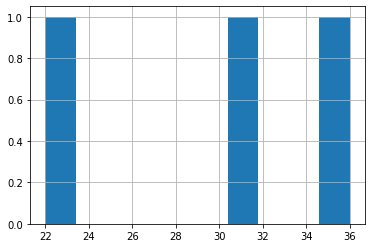

In [ ]:
len_sequences = []
for one_seq in sequence_cd:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).hist()

In [ ]:
#Padding the sequence with the values in last row to max length
to_pad = 36
new_seq = []
for one_seq in sequence_cd:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(34, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_cd = np.stack(new_seq)

#truncate the sequence to length 24
from keras.preprocessing import sequence
seq_len = 24
final_seq_cd=sequence.pad_sequences(final_seq_cd, maxlen=seq_len, padding='post', dtype='float', truncating='pre')

In [ ]:
#Padding the sequence with the values in last row to max length
to_pad = 23
new_seq = []
for one_seq in sequence_bd:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(34, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_bd = np.stack(new_seq)
#truncate the sequence to length 24
from keras.preprocessing import sequence
seq_len = 24
final_seq_bd=sequence.pad_sequences(final_seq_bd, maxlen=seq_len, padding='post', dtype='float', truncating='pre')

In [ ]:
#Padding the sequence with the values in last row to max length
to_pad = 36
new_seq = []
for one_seq in sequence_fd:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(34, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_fd = np.stack(new_seq)

#truncate the sequence to length 24
from keras.preprocessing import sequence
seq_len = 24
final_seq_fd=sequence.pad_sequences(final_seq_fd, maxlen=seq_len, padding='post', dtype='float', truncating='pre')

**Format data for classification**

In [ ]:
final_seq_bd = np.array(final_seq_bd)
final_seq_cd = np.array(final_seq_cd)
final_seq_fd = np.array(final_seq_fd)
final_seq_bd.shape

(3, 24, 34)

In [ ]:
final_seq_train = np.vstack((final_seq_bd,final_seq_cd,final_seq_fd))

In [ ]:
final_seq_train[0].shape

(24, 34)

In [ ]:
np.save("classify_this",final_seq_train)